# MEViT

This is the 3rd iteration of MEViT. In this one I will keep 50% of the dataset and experiment with the learning rate by increasing it to .1.

**NOTE:** Connect to a High-RAM Environment

# Training

Settings

In [1]:
# MODEL SETTINGS
model_name = 'mevit_model_3'
percentage_to_load = 50 / 100.0  # Set the % of dataset to be loaded here.

Imports

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

# Imports
import os
import cv2
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Flatten, Conv2DTranspose
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Data Loading

In [3]:
# Function to count files
def count_files(directory, extension=".tif"):
    return sum(1 for file in os.listdir(directory) if file.endswith(extension))

# Paths to your image and mask directories
image_directory = '/gdrive/My Drive/Dataset/patches/train/images/'
mask_directory = '/gdrive/My Drive/Dataset/patches/train/masks/'

# Counting the TIFF files in both directories
image_count = count_files(image_directory)
mask_count = count_files(mask_directory)

print(f"Number of image files: {image_count}")
print(f"Number of mask files: {mask_count}")

# Load the images and masks into the lists below
images = []
masks = []

# Sort filenames to ensure matching pairs align
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(mask_directory) if f.endswith(".tif")])

# Determine how many files to load based on percentage
number_of_files_to_load = int(len(image_files) * percentage_to_load)

# Create a mapping of image names to their corresponding mask names by removing '_Buildings'
image_to_mask = {f: f.replace("_patch", "_Buildings_patch") for f in image_files}

# Only iterate over the subset of files determined by the percentage
print(f'Attempting to load {percentage_to_load*100}% of dataset: {number_of_files_to_load} images/mask pairs...')
for count, image_name in enumerate(image_files[:number_of_files_to_load], start=1):
    img_path = os.path.join(image_directory, image_name)
    mask_name = image_to_mask[image_name]
    mask_path = os.path.join(mask_directory, mask_name)

    if os.path.exists(mask_path):
        img = tiff.imread(img_path)
        mask = tiff.imread(mask_path)

        images.append(img)
        masks.append(mask)
    else:
        print(f'\nMask not found for image: {image_name}')

    # Update the count in the same line
    print(f'\rProcessed: {count}/{number_of_files_to_load}', end='')

print("\nLoading complete.")

Number of image files: 4787
Number of mask files: 4787
Attempting to load 50.0% of dataset: 2393 images/mask pairs...
Processed: 2393/2393
Loading complete.


Normalization & Train/Test/Val Split

In [4]:
# Convert the lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

# Normalize the values
images /= 255.0
masks /= 255.0
masks = masks.reshape((-1, 256, 256, 1))

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=1995)

# Further split the training set into training and validation sets (90% train, 10% val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1995)

# If there is an unnecessary singleton dimension in your dataset, remove it:
if X_train.ndim > 3:
    X_train = X_train.squeeze(axis=1)
    X_val = X_val.squeeze(axis=1)
    X_test = X_test.squeeze(axis=1)

# Display the shapes of the datasets to confirm correct dimensions
print('Dataset Shapes:')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val:   {X_val.shape}, y_val: {y_val.shape}')
print(f'X_test:  {X_test.shape}, y_test: {y_test.shape}')

Dataset Shapes:
X_train: (1722, 256, 256, 3), y_train: (1722, 256, 256, 1)
X_val:   (192, 256, 256, 3), y_val: (192, 256, 256, 1)
X_test:  (479, 256, 256, 3), y_test: (479, 256, 256, 1)


Model Definition

In [5]:
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import LearningRateScheduler

# Custom Metrics
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def jaccard_index(y_true, y_pred, threshold=0.5):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

# Loss Function
def calculate_class_weights(masks):
    flat_labels = masks.flatten().astype(int)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(flat_labels), y=flat_labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    return class_weights_dict

def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weighted_bce = bce * (weights[1] * y_true + weights[0] * (1 - y_true))
        return tf.keras.backend.mean(weighted_bce)
    return loss

# Calculate the class weights for the training masks
class_weights = calculate_class_weights(y_train)
print("Class weights:", class_weights)
weighted_loss = weighted_binary_crossentropy(class_weights)

# Define the MEVit model
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_vit_segmentation_model(input_shape, num_classes, embed_dim, num_heads, ff_dim):
    inputs = layers.Input(shape=input_shape)
    # Flatten the input
    x = layers.Reshape((-1, input_shape[-1]))(inputs)

    # Create patches and embed
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patches = layers.Conv2D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patches = layers.Reshape((num_patches, embed_dim))(patches)

    # Add Transformer blocks
    for _ in range(8):
        patches = TransformerBlock(embed_dim, num_heads, ff_dim)(patches)

    # Reshape back to image
    x = layers.Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, embed_dim))(patches)
    x = Conv2DTranspose(num_classes, kernel_size=patch_size, strides=patch_size, padding="valid")(x)
    outputs = layers.Activation('sigmoid')(x)

    return Model(inputs, outputs)

Class weights: {0: 0.5339968946194886, 1: 7.853612816644959}


Model Compilation

In [6]:
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (256, 256, 3)
num_classes = 1
embed_dim = 64
num_heads = 4
ff_dim = 128

model = create_vit_segmentation_model(input_shape, num_classes, embed_dim, num_heads, ff_dim)
model._name = model_name
model.summary()

# Learning rate schedule
def lr_schedule(epoch, lr):
    if epoch >= 40 and epoch < 60:
        return lr * 0.1
    elif epoch >= 60:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model
sgd = SGD(learning_rate=0.1, momentum=0.9)
model.compile(
    optimizer=sgd,
    loss=weighted_loss,
    metrics=['accuracy', dice_coefficient, jaccard_index, sensitivity, specificity, precision]
)

# Setup callbacks
early_stopping = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=10,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    f'/gdrive/My Drive/Dataset/Models/best_{model_name}',  # Path where the model will be saved
    monitor='val_dice_coefficient',  # Save the model based on the maximum dice_coefficient value
    verbose=1,
    save_best_only=True,
    mode='max'
)

Model: "mevit_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        49216     
                                                                 
 reshape_1 (Reshape)         (None, 256, 64)           0         
                                                                 
 transformer_block (Transfo  (None, 256, 64)           83200     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 256, 64)           83200     
 formerBlock)                                                    
                                                                 
 transformer_block_2 (Trans  (None, 256, 64)         

Model Training

In [7]:
# Fit the model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=70,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping, lr_scheduler]
)

# Save the model
model.save(f'/gdrive/My Drive/Dataset/Models/{model_name}.h5')

Epoch 1/70
108/108 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5694 - dice_coefficient: 0.0910 - jaccard_index: 0.0481 - sensitivity: 0.4247 - specificity: 0.5793 - precision: 0.0647
Epoch 1: val_dice_coefficient improved from -inf to 0.00000, saving model to /gdrive/My Drive/Dataset/Models/best_mevit_model_3
108/108 [==============================] - 101s 845ms/step - loss: 0.6934 - accuracy: 0.5694 - dice_coefficient: 0.0910 - jaccard_index: 0.0481 - sensitivity: 0.4247 - specificity: 0.5793 - precision: 0.0647 - val_loss: 0.6869 - val_accuracy: 0.9381 - val_dice_coefficient: 1.5981e-12 - val_jaccard_index: 1.5981e-12 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9999 - val_precision: 0.0000e+00 - lr: 0.1000
Epoch 2/70
108/108 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5069 - dice_coefficient: 0.1059 - jaccard_index: 0.0571 - sensitivity: 0.5677 - specificity: 0.5038 - precision: 0.0711
Epoch 2: val_dice_coefficient improv

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation

Evaluation

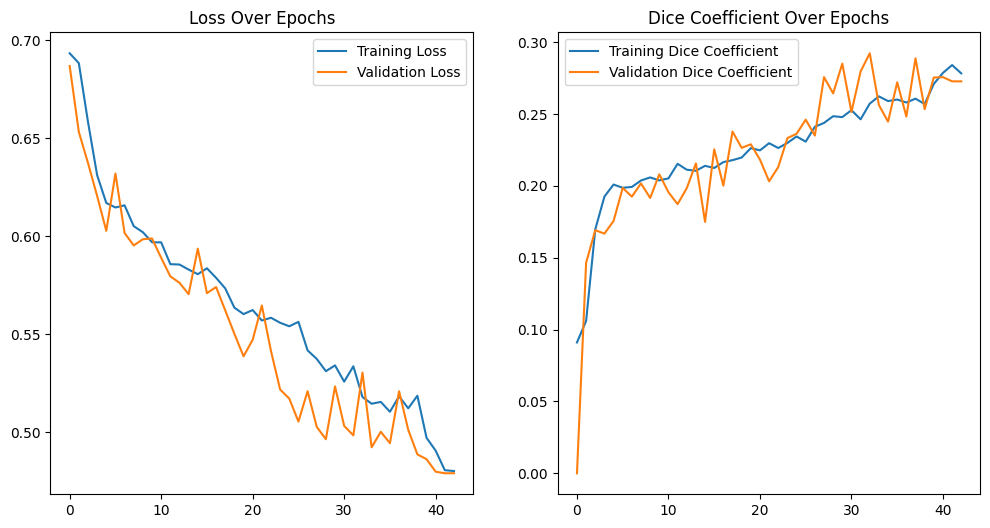

15/15 [==============================] - 10s 598ms/step


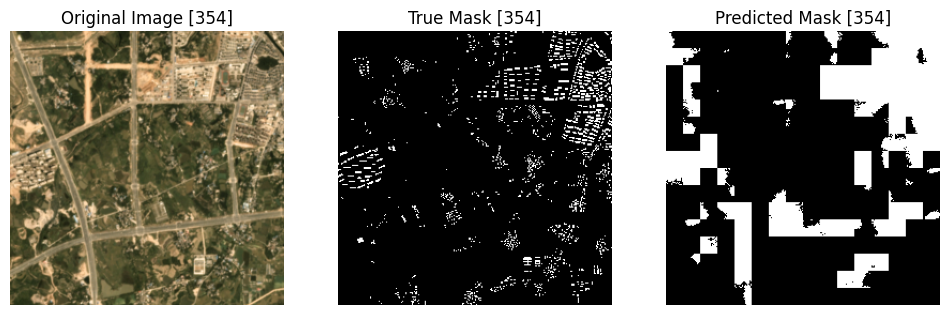

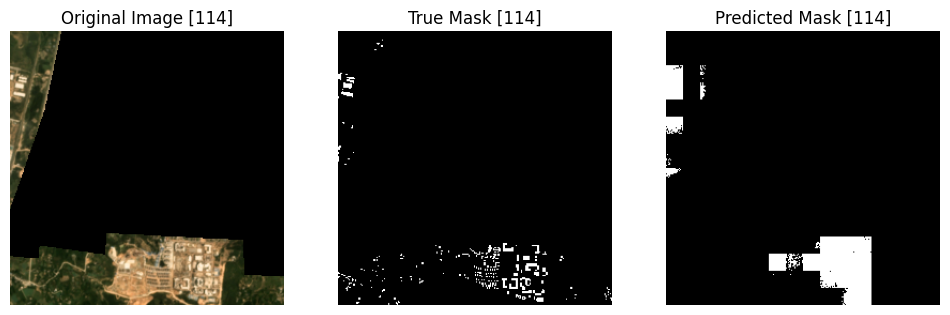

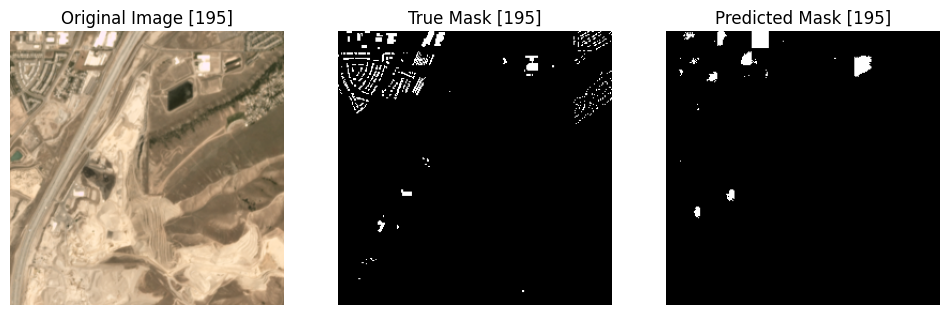

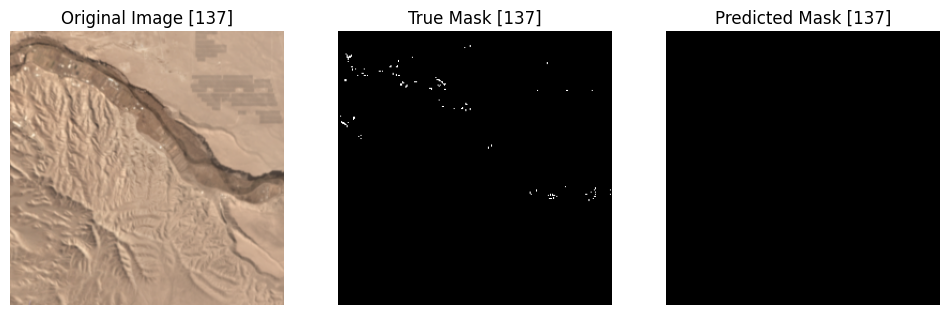

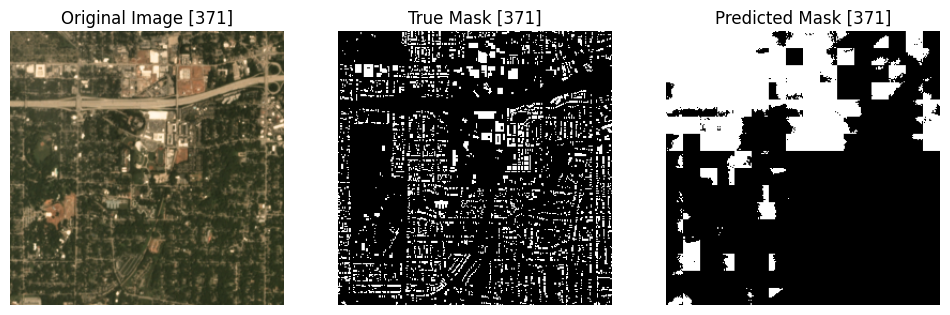

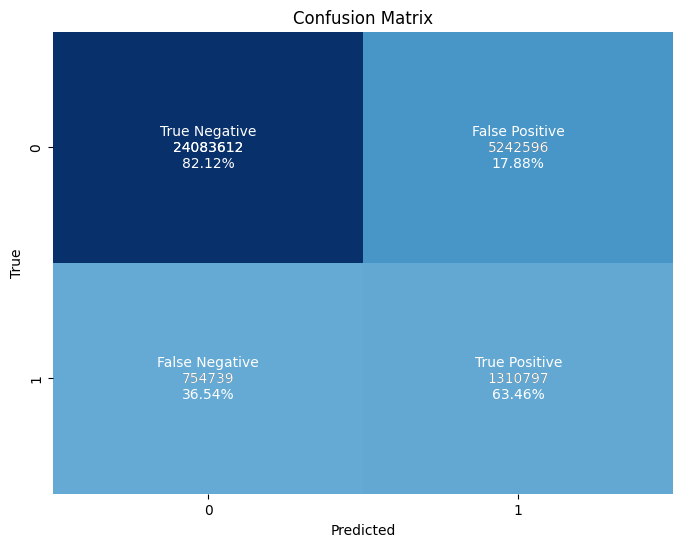

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89  29326208
         1.0       0.20      0.63      0.30   2065536

    accuracy                           0.81  31391744
   macro avg       0.58      0.73      0.60  31391744
weighted avg       0.92      0.81      0.85  31391744



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluation functions
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient Over Epochs')
    plt.legend()

    plt.show()

def show_predictions(X, y_true, y_pred, num_samples=5):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)

    for i in indices:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title(f'Original Image [{i}]')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title(f'True Mask [{i}]')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[i].squeeze() > 0.5, cmap='gray')  # Apply a threshold to convert probabilities to binary mask
        plt.title(f'Predicted Mask [{i}]')
        plt.axis('off')

        plt.show()

def plot_confusion_matrix(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(int)  # Thresholding probabilities

    cm = confusion_matrix(y_true_f, y_pred_f)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm_normalized.flatten()]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, center=0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Perform the evaluation
plot_training_history(history)
y_pred = model.predict(X_test)
show_predictions(X_test, y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test.flatten(), (y_pred.flatten() > 0.5).astype(int)))